# This notebook cleans and filters the data
Parse/convert the times from human readable to machine readable (e.g. "after school lets out" --> "3:00PM")
Parse the addresses to City, Zipcode (when available), State, Country
Use external lookup and custom city/state corrections to determine County for each address

## Imports

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import os,sys
import json
import re
import matplotlib.pyplot as plt
from datetime import date, datetime
import dateparser
from pprint import pprint

DATA_DIR = "data"

## Lookup for City->County and County->CountyFIPS matchings that have mismatching city names

In [2]:
city_reps = {"AR": {"Helena-West Helena":"West Helena",
                    "DeWitt":"Dewitt",
                    "Fargo":"Brinkley"},
            "CA": {"South Whittier":"Whittier",
                   "Florence-Graham":"Los Angeles",
                   "San Antonio":"San Rafael",
                   "Willowbrook":"Watts",
                   "Florence-Graham":"Oakwood"},
            "DE": {"Pennyhill":"Bear"},
            "FL": {"Opa-locka":"Opa Locka"},
            "GA": {"LaGrange":"Lagrange"},
            "IA": {"DeWitt":"Dewitt"},
            "IL": {"Glendale":"Cloverdale",
                   "DeKalb":"Dekalb"},
            "KS": {"Alta Mills":"Newton"},
            "LA": {"Phoenix":"Buras"},
            "MA": {"Manchester-by-the-Sea":"Manchester By The Sea"},
            "MD": {"Greater Landover":"Landover",
                   "Fair Hill":"Perryville"},
            "MI": {"Mt Morris Township":"Mount Morris",
                   "Calumet Twp":"Calumet",
                   "Kalamazoo Twp":"Kalamazoo",
                   "Charter Twp of Clinton":"Armada",
                   "Bridgeport Charter Township":"Bridgeport"},
            "MT": {"Bonner-West Riverside":"Bonner"},
            "NC": {"McLeansville":"Mcleansville",
                   "Feltonville":"Warrenton"},
            "NJ": {"Lafayette Township":"Lafayette",
                   "Bethlehem":"Califon",
                   "Upper Deerfield Township":"Upper Deerfield Twp",
                   "White": "Allamuchy"},
            "NY": {"Hartland":"Burt"},
            "OK": {"McAlester":"Mcalester"},
            "PA": {"West Conshohocken":"Conshohocken",
                   "McKeesport":"Mckeesport",
                   "Bensalem Township":"Bensalem",
                   "Wilkes-Barre":"Wilkes Barre",
                   "Warwick Township":"Deodate"},
            "SC": {"Dacusville":"Central"},
            "TX": {"Falcon Mesa":"Falcon"},
            "WI": {"DeForest":"De Forest",
                   "Ashford":"Eden",
                   "Mt Morris":"Coloma"},
            "WV": {"Davis Creek":"Belle"}
            }

county_reps = {
            "IL": {"DE WITT": "DEWITT"}
}

## Create a map from (County Name) to (State and County FIPS IDs) so we can uniquely and universally reference counties in outside datasets

Source: https://www.census.gov/geo/reference/codes/cou.html

In [3]:
counties_fp_raw = pd.read_csv(os.path.join(DATA_DIR, "national_county.txt"), header=None, names=[
    "State", "StateFP", "CountyFP", "County", "ClassFP"])
counties_fp_map = {}
for index, row in counties_fp_raw.iterrows():
    state = row["State"]
    state_fp = str(row["StateFP"])
    county = row["County"]
    county_fp = str(row["CountyFP"])
    
    state_fp = "0"*(2-len(state_fp)) + state_fp
    county_fp = "0"*(3-len(county_fp)) + county_fp  
    
    county = county.upper() \
        .replace(" COUNTY", "") \
        .replace(".", "") \
        .replace("'", "") \
        .replace("-", " ")
    
    if state in county_reps and county in county_reps[state]:
        county = county_reps[state][county]
    
    if state not in counties_fp_map:
        counties_fp_map[state] = {}
        
    counties_fp_map[state][county] = {"state":state_fp, "county":county_fp}

## Create map from State/City to County using external data
Source: https://github.com/grammakov/USA-cities-and-states/blob/master/us_cities_states_counties.csv

In [4]:
counties_map_raw = pd.read_csv(os.path.join(DATA_DIR, "us_cities_states_counties.csv"), delimiter="|")
counties_map_raw = counties_map_raw.where((pd.notnull(counties_map_raw)), None)
counties_fp_raw = counties_fp_raw.where((pd.notnull(counties_fp_raw)), None)

counties_map = {}
counties_map_alias = {}
for index, row in counties_map_raw.iterrows():
    state = row["State short"]
    city = row["City"]
    city_alias = row["City alias"]
    county_name = row["County"]
    
    if not state or not county_name or state in ["AE", "PW", "AS", "FM", "MP", "MH"]:
        continue
    try:
        q_county = [county_name, county_name.replace("-", " "), 
                    county_name + " CITY", county_name.replace("SAINT ", "ST "),
                    county_name.replace("SAINT ", "ST ") + " ISLAND",
                    county_name.replace("SAINT ", "ST ") + " PARISH",
                    county_name.replace("SAINTE ", "STE "),
                    county_name + " MUNICIPIO", county_name + " MUNICIPALITY",
                    county_name + " CENSUS AREA", county_name + " BOROUGH",
                    county_name + " CITY AND BOROUGH",
                    county_name + " ISLAND", county_name.replace(" ", "")]
    except:
        print(county_name)
    fp = None
    for c in q_county:
        if c in counties_fp_map[state]:
            fp = counties_fp_map[state][c]
            
    if not fp:
        print(state)
        print(county_name)
        continue
        
    state_fp = str(fp["state"])
    county_fp = str(fp["county"])
    state_fp = "0"*(2-len(state_fp)) + state_fp
    county_fp = "0"*(3-len(county_fp)) + county_fp
    
    if state not in counties_map:
        counties_map[state] = {}
    if city not in counties_map[state]:
        counties_map[state][city] = {"county_name":county_name, "county_fp":county_fp, "state_fp":state_fp}
    
    if state not in counties_map_alias:
        counties_map_alias[state] = {}
    if city_alias not in counties_map[state]:
        counties_map_alias[state][city_alias] = {"county_name":county_name, "county_fp":county_fp, "state_fp":state_fp}


## Create Map for County Lookup

### Population

In [27]:
pop_data_raw = pd.read_excel(os.path.join(DATA_DIR, "Population_2010_2016.xls"), skiprows=[0,1], header=0)
county_data_map = {}
for index, row in pop_data_raw.iterrows():
    fp = str(row["FIPS"])
    fp = "0"*(5-len(fp)) + fp
    state = row["State"]
    if state in ["PR"]:
        continue
    if county_fp not in county_data_map:
        county_data_map[fp] = {}
    if "pop" not in county_data_map[fp]:
        county_data_map[fp]["pop"] = {}
    pop_key = "POP_ESTIMATE_"
    for y in range(2010, 2017):
        pop = row[pop_key + str(y)]
        county_data_map[fp]["pop"][y] = str(pop)
    # Account for 2017 pop by adding half of the change from 2015-2016
    pop_2016 = int(row[pop_key + "2016"])
    est_chg_2017 = 0.5*int(row["N_POP_CHG_2016"])
    county_data_map[fp]["pop"][2017] = str(int(pop_2016 + est_chg_2017))

### Land Size

In [32]:
land_data_raw = pd.read_csv(os.path.join(DATA_DIR, "2010 Geo Data.csv"), encoding="ISO-8859-1", skiprows=[0], header=0)
for index, row in land_data_raw.iterrows():
    fp = row["Target Geo Id2"]
    if np.isnan(fp):
        fp = "00000"
    fp = str(int(fp))
    if len(fp) < 3:
        fp = fp + "000"
    fp = "0"*(5-len(fp)) + fp
    if fp not in county_data_map:
        county_data_map[fp] = {}
    land = row["Area in square miles - Land area"]
    county_data_map[fp]["land"] = land

### Unemployment

{'00000': {'land': 3531905.43,
  'pop': {2010: '309348193',
   2011: '311663358',
   2012: '313998379',
   2013: '316204908',
   2014: '318563456',
   2015: '320896618',
   2016: '323127513',
   2017: '324242960'}},
 '01000': {'land': 50645.33,
  'pop': {2010: '4785492',
   2011: '4799918',
   2012: '4815960',
   2013: '4829479',
   2014: '4843214',
   2015: '4853875',
   2016: '4863300',
   2017: '4868012'}},
 '01001': {'land': 594.44,
  'pop': {2010: '54742',
   2011: '55255',
   2012: '55027',
   2013: '54792',
   2014: '54977',
   2015: '55035',
   2016: '55416',
   2017: '55606'}},
 '01003': {'land': 1589.78,
  'pop': {2010: '183199',
   2011: '186653',
   2012: '190403',
   2013: '195147',
   2014: '199745',
   2015: '203690',
   2016: '208563',
   2017: '210999'}},
 '01005': {'land': 884.88,
  'pop': {2010: '27348',
   2011: '27326',
   2012: '27132',
   2013: '26938',
   2014: '26763',
   2015: '26270',
   2016: '25965',
   2017: '25812'}},
 '01007': {'land': 622.58,
  'pop': {

## Parse human-readable address and determine counties / FIPS IDs

In [6]:
def parse_address(address):
    if not address:
        return None
    a = [_.strip() for _ in address.split(",")]
    cur = -1
    country = a[cur]
    cur -= 1
    zcode = None
    state = None
    city = None
    # State and Zip have no comma
    if -cur <= len(a):
        if len(a[cur]) > 5:
            state_zip = a[cur].split(" ")
            if len(state_zip) == 2:
                zcode = state_zip[1]
                state = state_zip[0]
                cur -= 1
        # Has zip
        elif len(a[cur]) > 2: 
            if -cur <= len(a):
                zcode = a[cur]
                cur -= 1
            if -cur <= len(a):
                state = a[cur]
                cur -= 1
        # Doesn't have zip
        else:
            if -cur <= len(a):
                state = a[cur]
                cur -= 1
        
    if -cur <= len(a):
        city = a[cur]
    
    #### Get County ####
    county = None
    city_orig = city
    
    if city:
        # Cleanup city name
        if state in city_reps and city in city_reps[state]:
            city = city_reps[state][city]

        city = city.replace("St.", "Saint")
        city = city.replace("Ste.", "Sainte")
        city = city.replace("ñ", "n")
        city = city.replace("-", " ")
        if city[:3] == "Mt ":
            city = "Mount " + city[3:]
        if city[:3] == "St ":
            city = "Saint " + city[3:]

        if state in counties_map:
            if city in counties_map[state]:
                county = counties_map[state][city]
            elif city in counties_map_alias[state]:
                county = counties_map_alias[state][city]

    return county, city_orig, state, zcode, country

## Parse time and convert to machine-readable format since the data is very unstructured and inconsistent

In [7]:
def parse_time(fts, cts, recurse=True):
    fine_time = ""
    coarse_time = ""
    orig_fts = fts
    orig_cts = cts
    
    stop_chars = ['.', ',']
    days = ["monday", "tuesday", "wednesday", 
            "thursday", "friday", "saturday", "sunday"]
    
    numbers = ["one", "two", "three", "four", "five", "six", 
               "seven", "eight", "nine", "ten", "eleven", "twelve"]
    
    # Get fine time from clock-time
    fts = fts.lower()
    fts = fts.replace("p. m.", "p.m.")
    fts = fts.replace("a.m.", "a.m.")
    fts = fts.strip()
    fts = re.sub(r"([0-9]+)\.([0-9]+)", r"\1:\2", fts)
    fts = re.sub(r"([0-9]+)[ ]*\:[ ]*([0-9]+)", r"\1:\2", fts)
    for i, number in enumerate(numbers):
        fts = fts.replace(number, str(i+1))
    
    while fts and not fts[0].isdigit():
        fts = fts[1:]
    if fts:
        try:
            fine_time = dateparser.parse(fts).time()
        except:
            # Just keep going if you couldn't figure it out
            _ = True
            #print("Fine Time Parse Error 1: '" + orig_fts + "'  |  '" + orig_cts + "'")
        
    # Get coarse time from time-day
    cts = cts.lower()
    coarse_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    
    for day in days:
        cts = cts.replace(day, '')
    for c in stop_chars:
        cts = cts.replace(c, '')
    cts = cts.replace('  ', ' ')
    cts = cts.strip()
    if cts == "":
        coarse_time = ""
    elif cts in ["early morning", "dawn"] or \
        ("early" in cts and "morning" in cts) or "wake" in cts:
        coarse_time = coarse_time.replace(hour=7)
    elif ("early" in cts and "afternoon" in "cts") or "noon" in cts or "lunchtime" in cts:
        coarse_time = coarse_time.replace(hour=12)
    elif cts in ["morning", "am", "am", "early"]:
        coarse_time = coarse_time.replace(hour=10)
    elif cts in ["afternoon", "pm", "mid-day", "midday"] or "after school" in cts:
        coarse_time = coarse_time.replace(hour=15)
    elif cts in ["night", "evening", "late"] or "night" in cts or "nigh" in cts \
        or "after business" in cts or "dinnertime" in cts:
        coarse_time = coarse_time.replace(hour=21)
    elif cts == "midnight" or "midnight" in cts:
        coarse_time = coarse_time.replace(hour=0)
    elif cts in ["overnight", "before dawn"]:
        #TODO: Make this the next day (maybe that doesn't matter)
        # .    Could be good enough to indicate "3am" or something
        # .    since the day doesn't matter when examining time of day
        # .    as an independent factor
        coarse_time = coarse_time.replace(hour=3)
    # Repeat this later in the priority list in case we hit "early afternoon" or something
    elif "early" in cts:
        coarse_time = coarse_time.replace(hour=10)
    else:
        coarse_time = ""
        if not fine_time:
            while cts and not cts[0].isdigit():
                cts = cts[1:]
            if cts:
                try:
                    fine_time = dateparser.parse(cts).time()
                except:
                    # Just keep going if you couldn't figure it out
                    _ = True
                    #print("Coarse Time Parse Error 1: '" + orig_fts + "'  |  '" + orig_cts + "'")
    # If no time was found, switch the two and try to parse
    # This helps because sometimes the coarse time has something like "2 a.m" 
    # and the fine time has something like "midnight"
    if coarse_time:
        coarse_time = coarse_time.time()
    if recurse and not fine_time and not coarse_time:
        fine_time, coarse_time = parse_time(orig_cts, orig_fts, recurse=False)
    return fine_time, coarse_time

## Read data and use parsers to clean it up

In [ ]:
events_raw = pd.read_csv(os.path.join(DATA_DIR, "Events.tsv"), delimiter="\t")
events_raw.columns = ["Address", "Date", "Details", "Participants"]
events = pd.DataFrame(columns=["Address", "Details", "Country", "State", "StateFP",
                               "County","CountyFP", "City", "Zipcode", "Population",
                               "Date", "Fine Time", "Coarse Time", 
                               "Shots Fired", "Gun Type", "Participants"])

events["Date"] = events.Date.astype(datetime)
events["Zipcode"] = events.Zipcode.astype(int)
for index, event in events_raw.iterrows():
    new_event = {}
    new_event["Address"] = event["Address"]
    county, city, state, zcode, country = parse_address(event["Address"])
    new_event["Country"] = country
    new_event["State"] = state
    new_event["City"] = city
    new_event["Zipcode"] = zcode
    
    new_event["Date"] = datetime.strptime(event["Date"][:-6], 
                                          "%Y-%m-%d %H:%M:%S").date()
    # Incorrect date entry
    if new_event["Date"].year == 2026:
        new_event["Date"] = new_event["Date"].replace(year=2016)
        
    if county:
        county_fp = county["county_fp"]
        state_fp = county["state_fp"]
        new_event["StateFP"] = state_fp
        new_event["County"] = county["county_name"]
        new_event["CountyFP"] = county_fp
        year = new_event["Date"].year
    
        if year >= 2010 and year <= 2017:
            fp = str(state_fp) + str(county_fp)
            fp = "0"*(5-len(fp)) + fp
            new_event["Population"] = county_data_map[fp]["pop"][year]
        
    event_details = json.loads(event["Details"])
    fine_time, coarse_time = parse_time(event_details["clock-time"]["value"], 
                                    event_details["time-day"]["value"])
    new_event["Details"] = event_details["details"]["value"]
    new_event["Fine Time"] = fine_time
    new_event["Coarse Time"] = coarse_time
    new_event["Shots Fired"] = event_details["number-of-shots-fired"]["value"]
    new_event["Gun Type"] = event_details["type-of-gun"]["value"]
    new_event["Participants"] = event["Participants"]
    events = events.append(new_event, ignore_index=True)

## Plot data to determine how to filter

In [9]:
# Collect data on dates and times of shootings
# Prefer Fine Time to Coarse Time if the record has it
event_dates = []
event_times = []
for index, event in events.iterrows():
    event_dates.append(event["Date"])
    if event["Fine Time"]:
        event_times.append(event["Fine Time"])
    else:
        event_times.append(event["Coarse Time"])

In [10]:
# Create bar charts of # events by year and # events by time of day
num_events_by_year = []
years = range(2000, 2018)
for year in years:
    start = date(year, 1, 1)
    end = date(year, 12,31)
    events_in_year = len([d for d in event_dates if d >= start and d <= end])
    num_events_by_year.append(events_in_year)
    
num_events_by_tod = []
time_ranges = [(0, 6), (6, 12), (12, 18), (18, 0)]
for tr in time_ranges:
    start = datetime.now().replace(hour=tr[0], minute=0, second=0, microsecond=0).time()
    end = datetime.now().replace(hour=(tr[1]-1) % 24, minute=59, second=59, microsecond=0).time()
    events_in_time_range = len([t for t in event_times if t and t >= start and t <= end])
    num_events_by_tod.append(events_in_time_range)
    
num_empty_times = len([t for t in event_times if not t])

print("%d total events" % len(event_times))
print("%d events with no time" % num_empty_times)

3524 total events
942 events with no time


Text(0,0.5,'Number of Gun Violence Events')

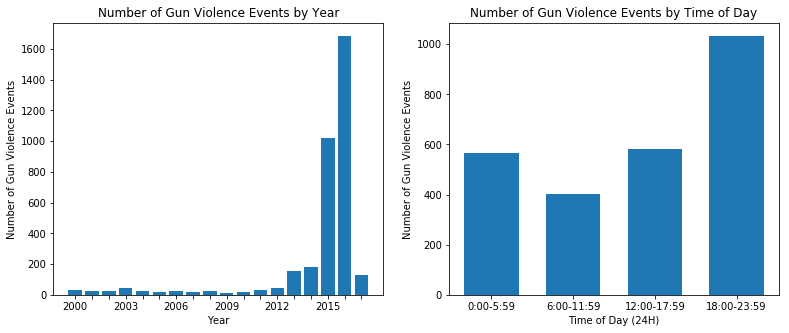

In [11]:
# Show the graphs
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].bar(years, num_events_by_year, tick_label=[str(year) if i % 3 == 0 else "" for i, year in enumerate(years)])
ax[0].set_title("Number of Gun Violence Events by Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Number of Gun Violence Events")

ax[1].bar([tr[0] for tr in time_ranges], num_events_by_tod, width=4,
        tick_label=["0:00-5:59", "6:00-11:59", "12:00-17:59", "18:00-23:59"])
ax[1].set_title("Number of Gun Violence Events by Time of Day")
ax[1].set_xlabel("Time of Day (24H)")
ax[1].set_ylabel("Number of Gun Violence Events")

The first graph indicates that our data is very heavily biased towards more recent events, and specifically 2016. No other data source cites a climb in gun violence of 800% from 2014 to 2016, so this bias is likely from more recent reports being available, or the data collection process.

The second graph indicates that between 6PM and midnight is the most likely time for gun violence to occur. It is roughly twice as likely in that time range than in any other.

## Filter such that we take only data from US after 2010
The data outside the US is extremely sparse and would not contribute to our work

The most recent census is from 2010 and removing data from before 2010 does not significantly impact our sample size. In addition, data from too long ago introduces a variable that we don't have enough data to account for (e.g. changes across decades)

In [12]:
usa_indices = []
date_2010 = date(2010, 1, 1)
for index, event in events.iterrows():
    address = event["Address"]
    if address.endswith("USA") and event["Date"] > date_2010:
        usa_indices.append(index)
usa_events = events.iloc[usa_indices]

In [13]:
# Write clean data to CSV
usa_events.to_csv(os.path.join(DATA_DIR, "Events_USA_2010.tsv"), sep="\t")